<a href="https://colab.research.google.com/github/perezsam/DM19-Lab2-Homework/blob/master/kaggle_competition_simple_text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load raw dataset ##

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.

from google.colab import files
files.upload()

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Dec 21 21:15 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!mkdir data

In [3]:
cd data

/content/data


In [4]:
# Copy the private data set locally.
!kaggle datasets download -d cssamuel/dmlab2

 90% 134M/149M [00:05<00:00, 16.2MB/s]
100% 149M/149M [00:05<00:00, 26.4MB/s]


In [5]:
# unzip dataset in data directory
!unzip dmlab2.zip

Archive:  dmlab2.zip
  inflating: data_identification.csv  
  inflating: emotion.csv             
  inflating: sampleSubmission.csv    
  inflating: tweets_DM.json          


In [6]:
# list files in current directory
ls

data_identification.csv  emotion.csv           tweets_DM.json
dmlab2.zip               sampleSubmission.csv


In [7]:
# return notebook directory
cd ..

/content


In [8]:
ls

data/  kaggle.json  sample_data/


##Data preprocessing##

We start by installing the emoji library for dealing with the emojis in tweets

In [23]:
# needed when working with text preprocessing for our model
!pip install emoji

We proceed to import some packeges and doing some setting configurations

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

np.random.seed(37)
KAGGLE_ENV = os.getcwd == '/kaggle/working'

We load and process the raw data using the json and json json_normalize

In [0]:
## to deal with the raw data we need json and json_normalize
import json
from pandas.io.json import json_normalize

In [0]:
# read raw data files
raw_data=pd.read_json("./data/tweets_DM.json",lines=True)

# get only the useful information from from tweets_DM.json
tweets=json_normalize(data=raw_data['_source'])

# read data identification and enotions
identify=pd.read_csv("./data/data_identification.csv")
emotion=pd.read_csv("./data/emotion.csv")

In [17]:
tweets.head()

,tweet.hashtags,tweet.tweet_id,tweet.text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be dehydrated. Cuz man.... that's <LH>"
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy. #CNN"
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, knowing that you will do even more than I ask. (Philemon 1:21) 3/4 #bibleverse <LH> <LH>"
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is someone you trust. Putting faith in anyone is a mistake."" ~ Christopher Hitchens <LH> <LH>"


Obtain our training and testing dataset by adding the identification to all tweets and then adding the emotion to the training dataset.

In [18]:
# rename column names given by the json_normalize
tweets=tweets.rename(index=str,columns={"tweet.text":"text", "tweet.tweet_id":"tweet_id",
                                       "tweet.hashtags":"hashtags"})
# add identify tags to dataframe
tweets=pd.merge(tweets,identify, on="tweet_id")

#get training set and test set
train_df=tweets[tweets["identification"] == "train"]
test_df=tweets[tweets["identification"] == "test"]

#add emotion column
train_df=pd.merge(train_df,emotion, on="tweet_id")
#test_df["emotion"]=""

#drop identification tags
train_df.drop(columns=["identification"],inplace=True)
test_df.drop(columns=["identification"],inplace=True)

#use tweet_id as index
train_df.set_index("tweet_id",inplace=True)
test_df.set_index("tweet_id",inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We finally have our training and testing datasets ready

In [19]:
train_df.head()

,hashtags,text,emotion
tweet_id,,,
0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be dehydrated. Cuz man.... that's <LH>",anticipation
0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy. #CNN",sadness
0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
0x1d755c,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TIME tonight. What stories! Heartbreakingly <LH> #authentic #LaughOutLoud good!!,joy
0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,anticipation


In [20]:
test_df.head()

,hashtags,text
tweet_id,,
0x28b412,[bibleverse],"Confident of your obedience, I write to you, knowing that you will do even more than I ask. (Philemon 1:21) 3/4 #bibleverse <LH> <LH>"
0x2de201,[],"""Trust is not the same as faith. A friend is someone you trust. Putting faith in anyone is a mistake."" ~ Christopher Hitchens <LH> <LH>"
0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfied ? Is you goal really all about money ? #materialism #money #possessions <LH>
0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #GodsWork <LH>"
0x26289a,[],"In these tough times, who do YOU turn to as your symbol of hope? <LH>"


Save our training and testing dataset to a pickle file

In [0]:
!mkdir output

In [0]:
# save to pickle file
train_df.to_pickle("./output/train_df.pkl")
test_df.to_pickle("./output/test_df.pkl")

##Sentiment Analysis##

###Loading the data###

We read in the pickle files we just saved from the data preprocessing stage. We shuffle the data frame and get only the needed variables (i.e. text and emotion)

In [0]:
## load a pickle file
df = pd.read_pickle("./output/train_df.pkl")
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'emotion']]

 ## Data Exploration ##

### Target variable ###

There are eight different classes (emotions) we need to predict: *anger, anticipation, disgust,	fear,	joy, sadness, surprise and trust.*

As we can see below, the class labels are inblanced.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


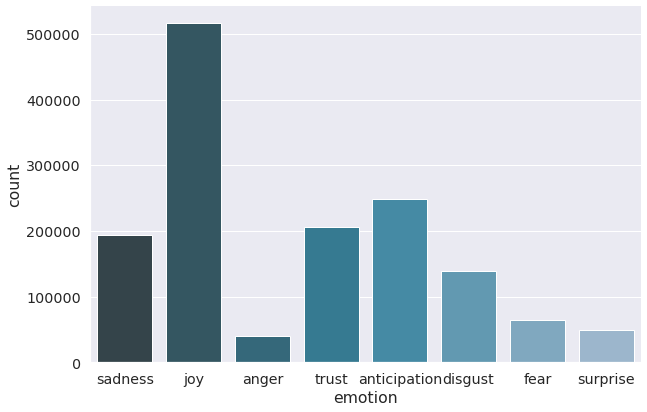

In [27]:
target_dist = sns.factorplot(x="emotion", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

To analyze the text variable a class **TextCounts** is created. In this class some basic statistics are computed on the text variable.

- **count_words** : number of words in the tweet
- **count_mentions** : referrals to other Twitter accounts, which are preceded by a @
- **count_hashtags** : number of tag words, preceded by a #
- **count_capital_words** : number of uppercase words, could be used to "shout" and express (negative) emotions
- **count_excl_quest_marks** : number of question or exclamation marks
- **count_urls** : number of links in the tweet, preceded by http(s)
- **count_emojis** : number of emoji, which might be a good indication of the sentiment

In [0]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [0]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
# Add tweet emotion to df_eda
df_eda['emotion'] = df.emotion

It could be interesting to see how the TextStats variables relate to the class variable. Therefore the function **show_dist** that provides descriptive statistics and a plot per target class.

In [0]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('emotion')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='emotion', size=5, hue='emotion', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show() 

Descriptive stats for count_words
---------------------------------
                 count       mean       std  min   25%   50%   75%   max
emotion                                                                 
anger         39867.0   16.126596  6.758856  2.0  10.0  16.0  22.0  34.0
anticipation  248935.0  16.477000  6.700404  2.0  11.0  17.0  22.0  38.0
disgust       139101.0  15.846838  6.480880  2.0  11.0  16.0  21.0  44.0
fear          63999.0   12.803919  6.619044  2.0  7.0   12.0  18.0  34.0
joy           516017.0  14.567594  6.539246  2.0  9.0   14.0  20.0  41.0
sadness       193437.0  15.166359  6.316717  2.0  10.0  15.0  20.0  37.0
surprise      48729.0   14.379322  6.689772  2.0  9.0   14.0  20.0  35.0
trust         205478.0  15.033230  6.390514  2.0  10.0  15.0  20.0  41.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


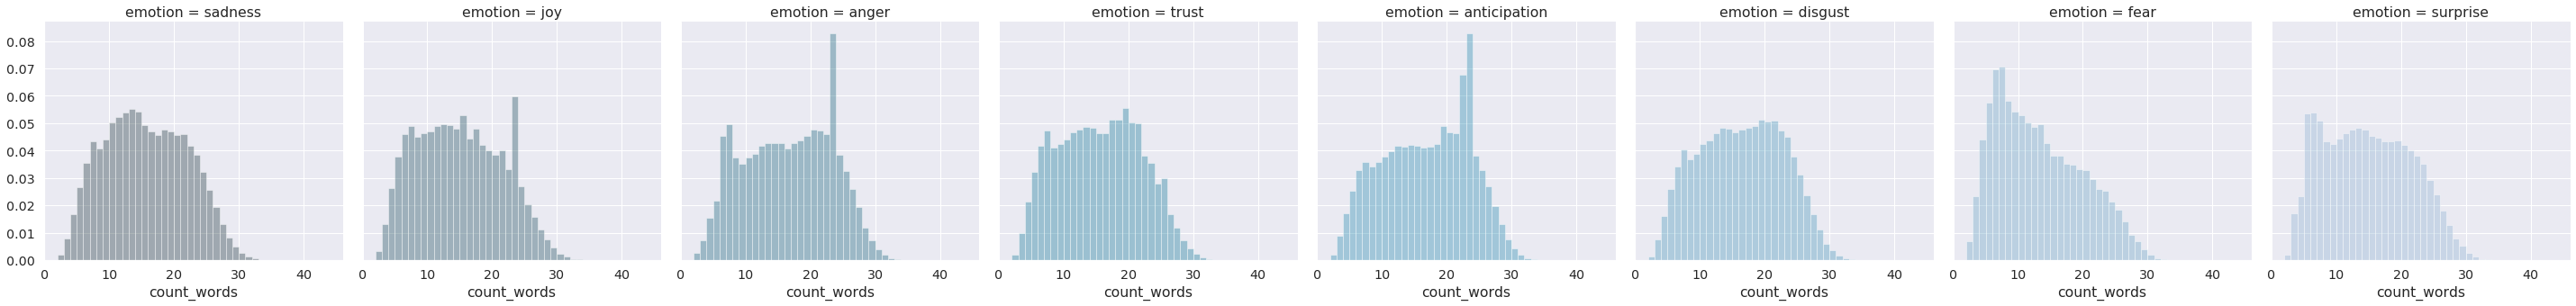

In [0]:
# show word count per emotion
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
                 count      mean       std  min  25%  50%  75%   max
emotion                                                             
anger         39867.0   0.468784  0.789897  0.0  0.0  0.0  1.0  8.0 
anticipation  248935.0  0.407331  0.792463  0.0  0.0  0.0  1.0  10.0
disgust       139101.0  0.753970  0.980680  0.0  0.0  0.0  1.0  12.0
fear          63999.0   0.456085  0.880535  0.0  0.0  0.0  1.0  9.0 
joy           516017.0  0.497563  0.899727  0.0  0.0  0.0  1.0  15.0
sadness       193437.0  0.912556  1.125350  0.0  0.0  1.0  1.0  12.0
surprise      48729.0   0.550699  0.905380  0.0  0.0  0.0  1.0  10.0
trust         205478.0  0.536310  0.934066  0.0  0.0  0.0  1.0  10.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


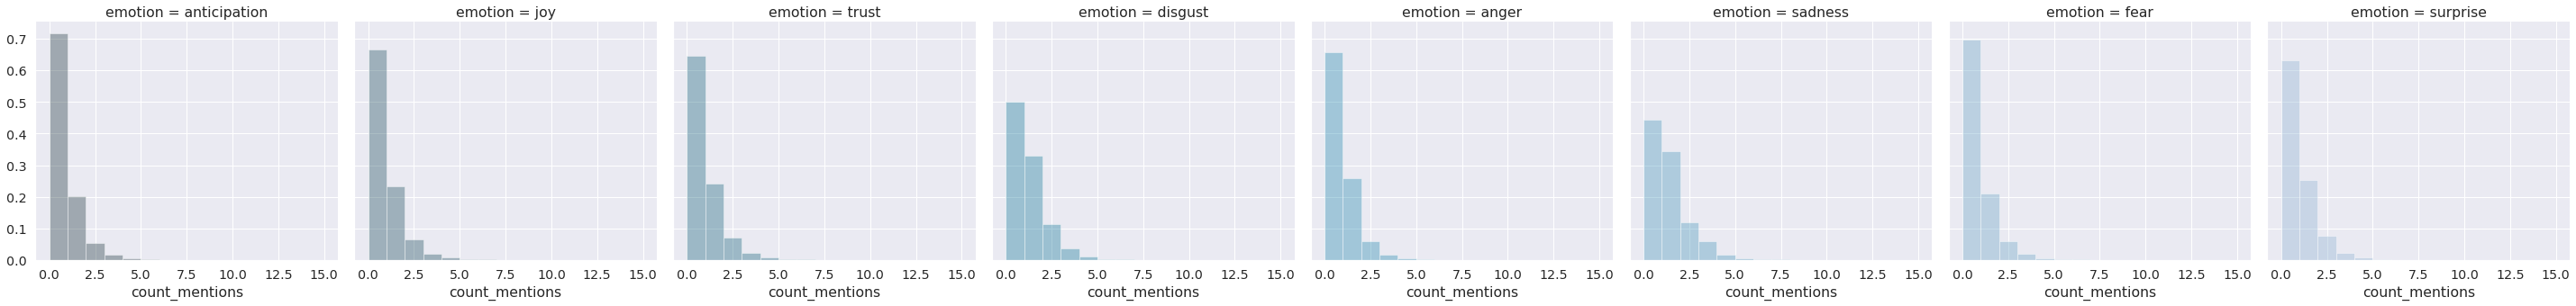

In [0]:
# show mentions count per emotion
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
                 count      mean       std  min  25%  50%  75%   max
emotion                                                             
anger         39867.0   0.969147  1.428140  0.0  0.0  0.0  1.0  15.0
anticipation  248935.0  1.296371  1.577434  0.0  0.0  1.0  2.0  20.0
disgust       139101.0  1.120855  1.435439  0.0  0.0  1.0  2.0  14.0
fear          63999.0   0.755262  1.320412  0.0  0.0  0.0  1.0  17.0
joy           516017.0  1.165111  1.624658  0.0  0.0  1.0  2.0  19.0
sadness       193437.0  0.948143  1.371936  0.0  0.0  1.0  1.0  17.0
surprise      48729.0   1.225820  1.724077  0.0  0.0  1.0  2.0  17.0
trust         205478.0  1.256266  1.660124  0.0  0.0  1.0  2.0  19.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


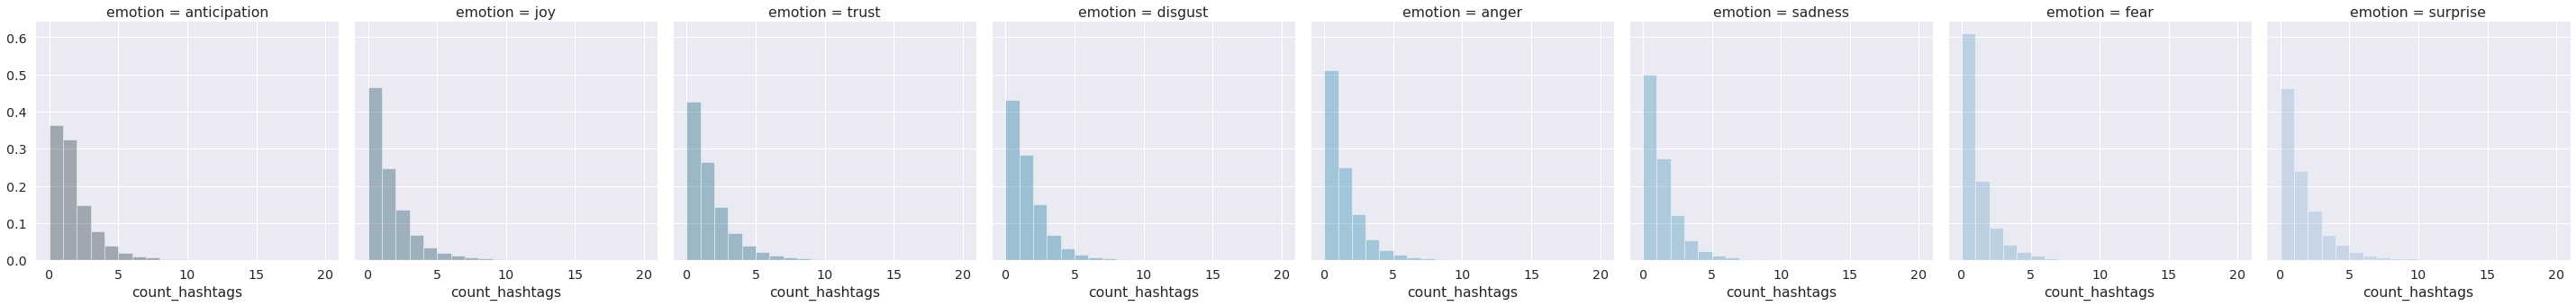

In [0]:
# show hashtags count per emotion
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
                 count      mean       std  min  25%  50%  75%   max
emotion                                                             
anger         39867.0   1.643891  1.987629  0.0  1.0  1.0  2.0  28.0
anticipation  248935.0  1.844871  1.859910  0.0  1.0  1.0  2.0  31.0
disgust       139101.0  1.462197  1.520690  0.0  1.0  1.0  2.0  29.0
fear          63999.0   1.347802  1.305162  0.0  1.0  1.0  1.0  30.0
joy           516017.0  1.736456  1.741254  0.0  1.0  1.0  2.0  30.0
sadness       193437.0  1.447314  1.355044  0.0  1.0  1.0  2.0  28.0
surprise      48729.0   1.544173  1.474940  0.0  1.0  1.0  2.0  27.0
trust         205478.0  1.513403  1.360580  0.0  1.0  1.0  2.0  29.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


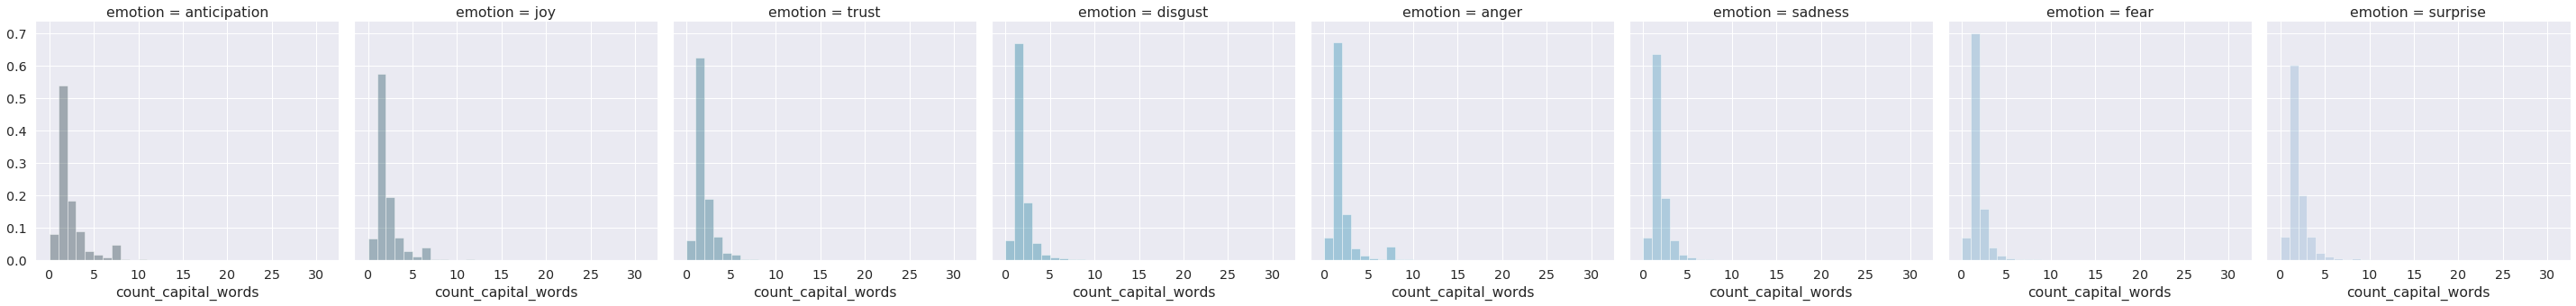

In [0]:
# show capital words count per emotion
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
                 count      mean       std  min  25%  50%  75%   max
emotion                                                             
anger         39867.0   0.599569  1.386444  0.0  0.0  0.0  1.0  77.0
anticipation  248935.0  0.475530  1.088577  0.0  0.0  0.0  1.0  90.0
disgust       139101.0  0.646149  1.318737  0.0  0.0  0.0  1.0  46.0
fear          63999.0   0.577322  1.238990  0.0  0.0  0.0  1.0  48.0
joy           516017.0  0.432344  1.090831  0.0  0.0  0.0  0.0  76.0
sadness       193437.0  0.488128  1.060462  0.0  0.0  0.0  1.0  31.0
surprise      48729.0   0.596852  1.198450  0.0  0.0  0.0  1.0  28.0
trust         205478.0  0.529701  1.104510  0.0  0.0  0.0  1.0  73.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


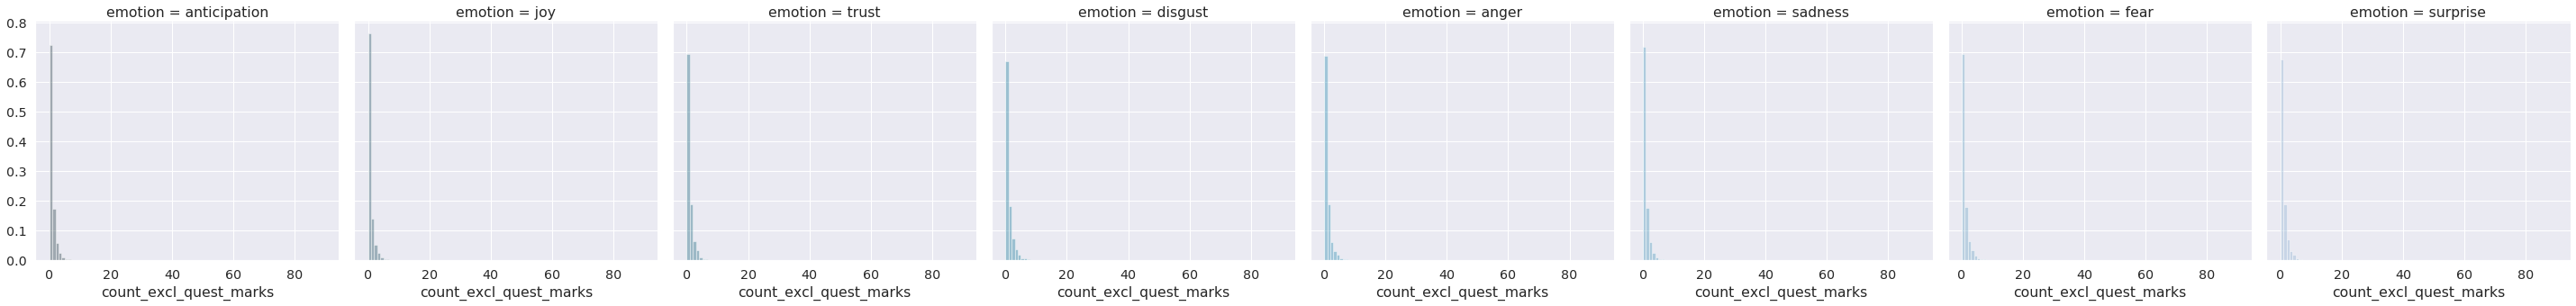

In [0]:
# show exclamation marks counts per emotion
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
                 count  mean  std  min  25%  50%  75%  max
emotion                                                   
anger         39867.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
anticipation  248935.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
disgust       139101.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
fear          63999.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
joy           516017.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
sadness       193437.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
surprise      48729.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
trust         205478.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


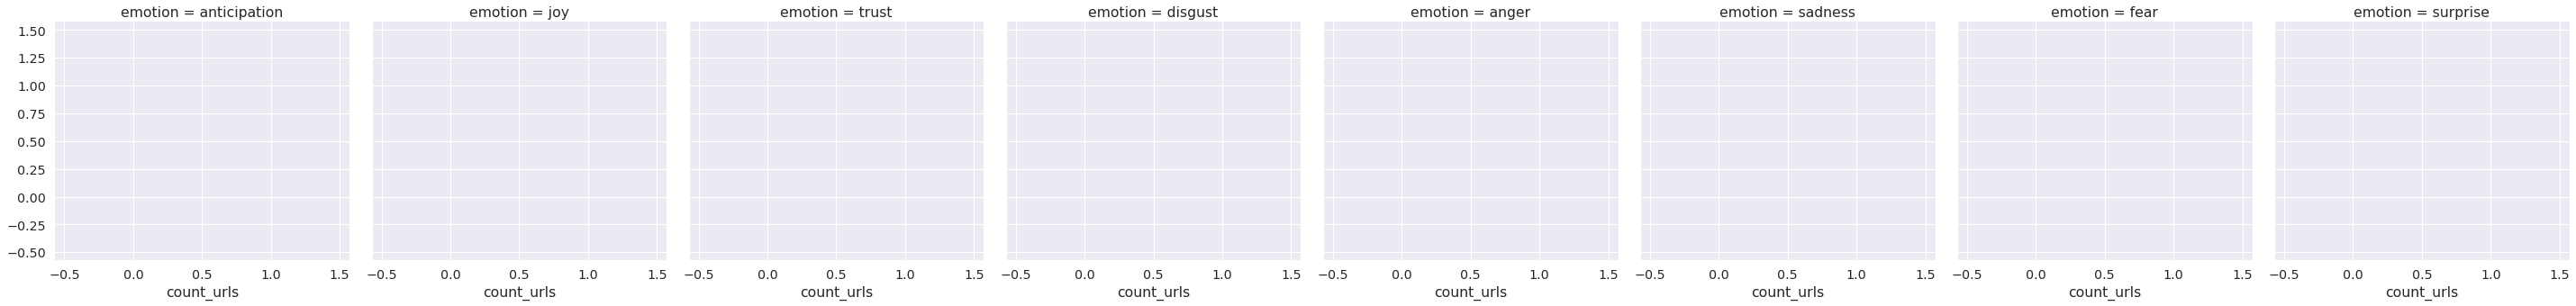

In [0]:
# show urls count per emotion
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
                 count      mean       std  min  25%  50%  75%    max
emotion                                                              
anger         39867.0   0.352898  1.183764  0.0  0.0  0.0  0.0  70.0 
anticipation  248935.0  0.347673  1.189058  0.0  0.0  0.0  0.0  78.0 
disgust       139101.0  0.267065  1.001759  0.0  0.0  0.0  0.0  70.0 
fear          63999.0   0.483023  1.360107  0.0  0.0  0.0  0.0  64.0 
joy           516017.0  0.536719  1.587650  0.0  0.0  0.0  0.0  119.0
sadness       193437.0  0.305071  1.067611  0.0  0.0  0.0  0.0  79.0 
surprise      48729.0   0.442139  1.256563  0.0  0.0  0.0  0.0  79.0 
trust         205478.0  0.471189  1.324633  0.0  0.0  0.0  0.0  116.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


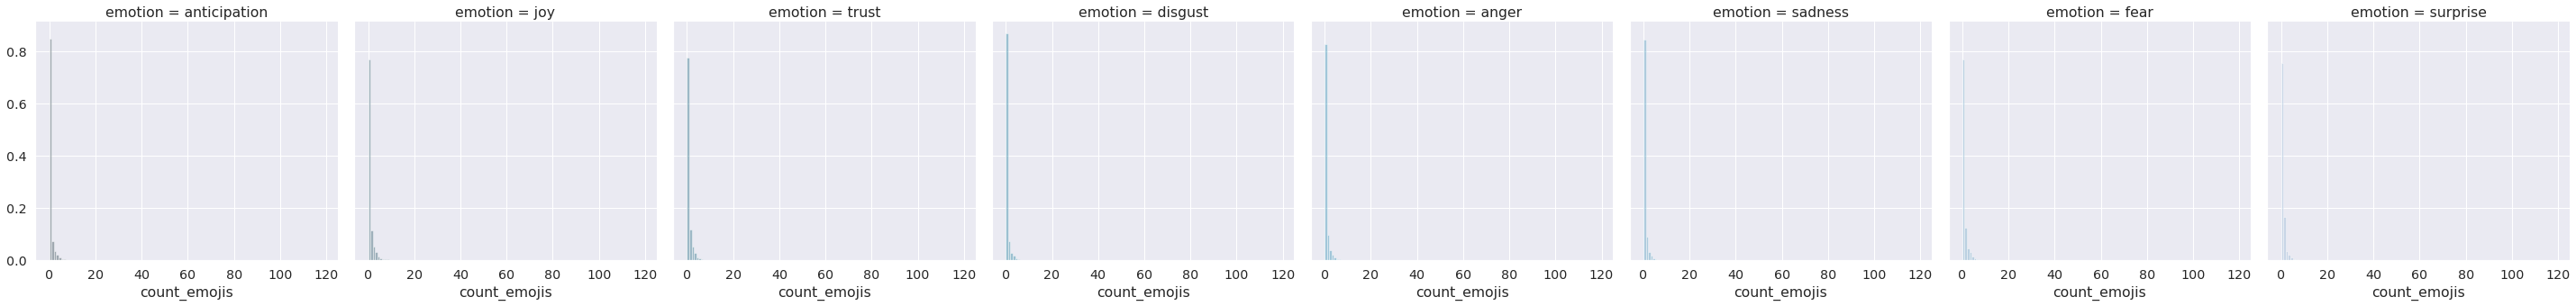

In [0]:
# show emojis count per emotion
show_dist(df_eda, 'count_emojis')

###Text Cleaning###

Before we start using the tweets' text we clean it. We'll do the this in the class CleanText:

- remove the mentions, as we want to make the model more general
- remove the hash tag sign (#) but not the actual tag as this may contain information
- set all words to lowercase
- remove all punctuations, including the question and exclamation marks
- the urls as they do not contain useful information and we did not notice a distinction in the number of urls used between the sentiment classes
- make sure the converted emojis are kept as one word.
- remove digits
- remove stopwords
- apply the PorterStemmer to keep the stem of the words

In [0]:
import nltk
nltk.download('stopwords')

class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


To show how the cleaned text variable will look like, here's a sample.

In [0]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

tweet_id
0x2cad92    shoot vega sad pray lh la vega lh shoot vega violenc    
0x372564    uni skip class studi midterm lh                         
0x1f3a0a    close sell lot eurusd pip total today pip lh lh lh lh lh
0x2508e3    bore realli feel like move bore lh ohioproblem          
0x242436    miss much lh wanna one 흥얼흥얼                             
Name: text, dtype: object


**NOTE:** One side-effect of text cleaning is that some rows do not have any words left in their text. For the CountVectorizer and TfIdfVectorizer this does not really pose a problem. However, for the Word2Vec algorithm this causes an error. There are different strategies that we could apply to deal with these missing values.

Remove the complete row, but in a production environment this is not really desirable.
Impute the missing value with some placeholder text like [no_text]
Word2Vec: use the average of all vectors

Here we will impute with a placeholder text.

In [0]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

3 records have no words left after text cleaning


Now that we have the cleaned text of the tweets, we can have a look at what are the most frequent words. Below we'll show the top 20 words.

The most frequent word is "love" after "lh" wich is the tag that was not removed.

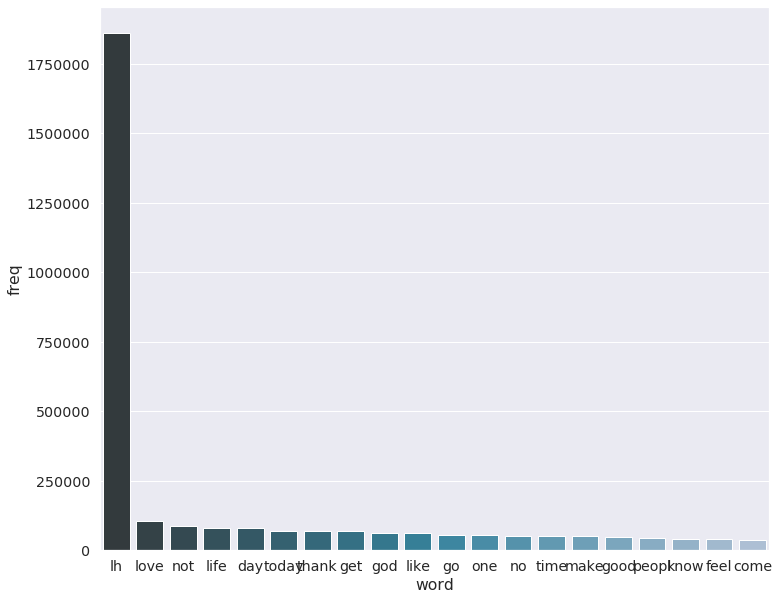

In [0]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

##Creating test data##

To evaluate the trained models we'll need a test set. Evaluating on the train data would not be correct because the models are trained to minimize their cost function.

First we combine the TextCounts variables with the CleanText variable.

In [0]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'emotion',
 'clean_text']

So df_model now contains several variables. However, our vectorizers (see below) will only need the clean_text variable. The TextCounts variables can be added as such. To specifically select columns.

In [0]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('emotion', axis=1), df_model.emotion, test_size=0.1, random_state=37)

###Hyperparameter tuning and cross-validation###

As we will see below, the vectorizers and classifiers all have configurable parameters. In order to chose the best parameters, we need to evaluate on a separate validation set that was not used during the training. However, using only one validation set may not produce reliable validation results. Due to chance you might have a good model performance on the validation set. If you would split the data otherwise, you might end up with other results. To get a more accurate estimation, we perform cross-validation.

With cross-validation the data is split into a train and validation set multiple times. The evaluation metric is then averaged over the different folds. Luckily, GridSearchCV applies cross-validation out-of-the-box.

To find the best parameters for both a vectorizer and classifier, we create a Pipeline. All this is put into a function for ease of use.

###Evaluation metrics###
By default GridSearchCV uses the default scorer to compute the bestscore. For both the MultiNomialNb and LogisticRegression this default scoring metric is the accuracy.

In our function grid_vect we additionally generate the classification_report on the test data. This provides some interesting metrics per target class, which might be more appropriate here. These metrics are the precision, recal and F1 score.

- **Precision**: Of all rows we predicted to be a certain class, how many did we correctly predict?
- **Recall**: Of all rows of a certain class, how many did we correctly predict?
- **F1 score**: Harmonic mean of Precision and Recall.
Precision and Recall can be calculated with the elements of the confusion matrix

In [0]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

###Parameter grids for GridSearchCV###

In [0]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

##Classifiers##

Here we will compare the performance of a MultinomailNB and LogisticRegression.

In [0]:
mnb = MultinomialNB()
logreg = LogisticRegression()

###CountVectorizer###

To use words in a classifier, we need to convert the words to numbers. This can be done with a **CountVectorizer**. Sklearn's CountVectorizer takes all words in all tweets, assigns an ID and counts the frequency of the word per tweet. This bag of words can then be used as input for a classifier. It is what is called a **sparse** data set, meaning that each record will have many zeroes for the words not occurring in the tweet.

In [0]:
countvect = CountVectorizer()

In [0]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
if not KAGGLE_ENV: joblib.dump(best_mnb_countvect, './output/best_mnb_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 54.2min finished


done in 3423.500s

Best CV score: 0.541
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.544


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.93      0.10      0.19      3928
anticipation       0.60      0.58      0.59     25019
     disgust       0.47      0.38      0.42     13992
        fear       0.85      0.27      0.40      6441
         joy       0.56      0.77      0.65     51543
     sadness       0.44      0.52      0.48     19403
    surprise       0.89      0.13      0.23      4709
       trust       0.52      0.32      0.40     20522

    accuracy                           0.54    145557
   macro avg       0.66      0.39      0.42    145557
weighted avg       0.57      0.54      0.52    145557



In [0]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
if not KAGGLE_ENV: joblib.dump(best_logreg_countvect, './output/best_logreg_countvect.pkl')

###TF-IDF###

One issue with CountVectorizer is that there might be words that occur frequently in observations of the target classes. These words do not have discriminatory information and can be removed. TF-IDF (term frequency - inverse document frequency) can be used to downweight these frequent words.

In [0]:
tfidfvect = TfidfVectorizer()

In [0]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
if not KAGGLE_ENV: joblib.dump(best_mnb_tfidf, './output/best_mnb_tfidf.pkl')

In [0]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
if not KAGGLE_ENV: joblib.dump(best_logreg_tfidf, './output/best_logreg_tfidf.pkl')

###Apply the best model on new tweets###

After running the grid search we can train our model with the best found parameters

In [0]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=1.0, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('emotion', axis=1), df_model.aemotion)

**NOTE:** In this particular notebook I did not run all cells due to time contraints wen working in google colab, however I run the grid search in another notebook when working with the homework and obtained the most suitable parameters. 

An accuracy of 45.3% was obtained on the leaderboard using CountVectorizer with MultinomailNB model, and an accuracy of 46.11 % was obtained on the leaderboard when using CountVectorizer with LogisticRegression model.